In [1]:
import math
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
from polar_quadtree import PolarNode, PolarQuadTree, cartesian_to_polar, hyperbolic_distance, polar_to_cartesian
import random
from timeit import default_timer as timer

### Data Generation

In [2]:
def generate_points(num_points: int):    
    # (1) GENERATE POINTS inside Poincaré disk via rejection sampling ————————————————————————————————————————————
    # i.e. Generate point inside [-1,1]^2 square, and reject if STRICTLY outside unit disk.
    points = []
    while len(points) != num_points:
        pt = np.random.uniform(-1, 1, 2)
        if np.linalg.norm(pt) < 1.0:  # strict inequality
            points.append(pt)

    points = np.array(points)
    return points

### Repulsive Forces (t-SNE)

In [45]:
def repulsive_forces_tsne(polar_points, points, quadtree=None):
    assert points.shape == polar_points.shape
    
    num_points = points.shape[0]
    #hyp_dists = np.zeros((num_points, num_points))
    hyp_dists = -np.ones((num_points, num_points))
    # This the matrix that stores the terms that, when summed up, correspond to the
    # variable Z
    Z_mat = np.zeros((num_points, num_points))
    
    # Vectorize this loop if we have time
    for k in range(num_points):
        for l in range(num_points):
            # If duplicates should not be summed, since the matrix is symmetric, 
            # we can store the values only when k < l i.e., Z_mat[k, l] = value 
            # when k < l and Z_mat[k, l] = 0 when k >= l
            
            if k >= l:
                continue
            
            if quadtree is not None:
                if hyp_dists[k, l] > 0:
                    continue
                    
                # Approximating nearest neighbors solution
                indices, distances = quadtree.query(points[k, :], polar_points[l, :], points[l, :], threshold=1.0)
                #print(f"k = {k} indices = {len(indices)} len = distances = {len(distances)}")
                #print(f"distances = {distances}")
                assert len(indices) > 0
                assert len(distances) > 0
                for idx, dist in zip(indices, distances):
                    #assert k < idx
                    hyp_dists[min(k, idx), max(k, idx)] = dist
                #print(f"k = {k} l = {l} polar node worst count = {PolarNode.worst_case_counter}")
            else:
                # Exact solution
                hyp_dists[k, l] = hyperbolic_distance(points[k, :], points[l, :])
            
            #Z_mat[min(k, l), max(k, l)] = 1.0 / (1 + hyp_dist**2)
            Z_mat[k, l] = 1.0 / (1 + hyp_dists[k, l]**2)
        #return
    
    Z = np.sum(Z_mat)
    force = 0.0
    for i in range(num_points):
        for j in range(num_points):
            if i >= j:
                continue
            
            q_ij = Z_mat[i, j] / Z
            force += (q_ij**2) * Z * (points[i, :] - points[j, :])
        
    
    return force

### Repulsive Forces (CO-SNE)

In [51]:
def repulsive_forces_cosne(polar_points, points, quadtree=None):
    assert points.shape == polar_points.shape
    
    num_points = points.shape[0]
    #hyp_dists = np.zeros((num_points, num_points))
    hyp_dists = -np.ones((num_points, num_points))
    # This the matrix that stores the terms that, when summed up, correspond to the
    # variable Z
    Z_mat = np.zeros((num_points, num_points))
    
    # Vectorize this loop if we have time
    for k in range(num_points):
        for l in range(num_points):
            # If duplicates should not be summed, since the matrix is symmetric, 
            # we can store the values only when k < l i.e., Z_mat[k, l] = value 
            # when k < l and Z_mat[k, l] = 0 when k >= l
            
            if k >= l:
                continue
            
            if quadtree is not None:
                if hyp_dists[k, l] > 0:
                    continue
                    
                # Approximating nearest neighbors solution
                indices, distances = quadtree.query(points[k, :], polar_points[l, :], points[l, :], threshold=1.0)
                #print(f"k = {k} indices = {len(indices)} len = distances = {len(distances)}")
                #print(f"distances = {distances}")
                assert len(indices) > 0
                assert len(distances) > 0
                for idx, dist in zip(indices, distances):
                    #assert k < idx
                    hyp_dists[min(k, idx), max(k, idx)] = dist
                #print(f"k = {k} l = {l} polar node worst count = {PolarNode.worst_case_counter}")
            else:
                # Exact solution
                hyp_dists[k, l] = hyperbolic_distance(points[k, :], points[l, :])
            
            #Z_mat[min(k, l), max(k, l)] = 1.0 / (1 + hyp_dist**2)
            Z_mat[k, l] = 1.0 / (1 + hyp_dists[k, l]**2)
        #return

    Z = np.sum(Z_mat)
    force = 0.0
    for i in range(num_points):
        for j in range(num_points):
            if i >= j:
                continue
            
            alpha = 1 - hyp_dists[i, i]**2**2
            #print("hyp_dists[i, i]**2 for i=", i, " is ", hyp_dists[i, i]**2)
            beta = 1 - hyp_dists[j, j]**2**2
            #print("hyp_dists[j, j]**2 for j=", j, " is ", hyp_dists[j, j]**2)
            if alpha == 0:
                #print("alpha is zero")
                continue
            if beta == 0:
                #print("beta is zero")
                continue
            

            gamma = 1 + (2*hyp_dists[i, j]**2**2)/(alpha*beta)
            coeff_i = (hyp_dists[i, i]**2**2-2*hyp_dists[i, j]**2+1)/(alpha**2)
            coeff_j = 1/alpha
            q_ij = Z_mat[i, j] / Z
            force += q_ij * Z * (4/(beta*np.sqrt(gamma**2-1))) * (coeff_i*points[i, :] - coeff_j*points[j, :])
        
    
    return force

### Results methods

In [91]:
def time_polar_tree_results_tsne(n):
    gridsearch_num_points = [n]

    polar_tree_results_tsne = []
    polar_tree_timing_tsne = []
    for num_points in gridsearch_num_points:
        cartesian_points = generate_points(num_points)
        polar_points = cartesian_to_polar(cartesian_points)
    
        tree = PolarQuadTree.from_cartesian_points(cartesian_points)
        start = timer()
        F_rep_tsne = repulsive_forces_tsne(polar_points, cartesian_points, tree)
        end = timer()
    
        polar_tree_results_tsne.append(F_rep_tsne)
        polar_tree_timing_tsne.append(end - start)
    return (end - start)

def time_polar_tree_results_cosne(n):
    gridsearch_num_points = [n]

    polar_tree_results_cosne = []
    polar_tree_timing_cosne = []
    for num_points in gridsearch_num_points:
        cartesian_points = generate_points(num_points)
        polar_points = cartesian_to_polar(cartesian_points)
    
        tree = PolarQuadTree.from_cartesian_points(cartesian_points)
        start = timer()
        F_rep_tsne = repulsive_forces_cosne(polar_points, cartesian_points, tree)
        end = timer()
    
        polar_tree_results_cosne.append(F_rep_tsne)
        polar_tree_timing_cosne.append(end - start)
    return (end - start)

def time_exact_results_tsne(n):
    gridsearch_num_points = [n]
    
    exact_results_tsne = []
    exact_timing_tsne = []
    for num_points in gridsearch_num_points:
        cartesian_points = generate_points(num_points)
        polar_points = cartesian_to_polar(cartesian_points)
    
        start = timer()
        F_rep = repulsive_forces_tsne(polar_points, cartesian_points)
        end = timer()
    
        exact_results_tsne.append(F_rep)
        exact_timing_tsne.append(end - start)
    return (end - start)

def time_exact_results_cosne(n):
    gridsearch_num_points = [n]
    
    exact_results_cosne = []
    exact_timing_cosne = []
    for num_points in gridsearch_num_points:
        cartesian_points = generate_points(num_points)
        polar_points = cartesian_to_polar(cartesian_points)
    
        start = timer()
        F_rep = repulsive_forces_cosne(polar_points, cartesian_points)
        end = timer()
    
        exact_results_cosne.append(F_rep)
        exact_timing_cosne.append(end - start)
    return (end - start)

### Pipeline

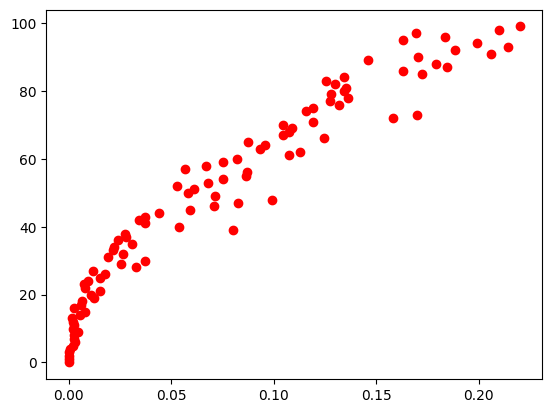

In [118]:
time = np.zeros(100)
timeMATRIX_polar_tree_results_tsne = np.zeros(100)
time[0] = 0
timeMATRIX_polar_tree_results_tsne[0] = 0
for i in range(1, 100):
    time[i] = i
    timeMATRIX_polar_tree_results_tsne[i] = time_polar_tree_results_tsne(i)

plt.plot(timeMATRIX_polar_tree_results_tsne, time, 'ro')
plt.show()

#time_polar_tree_results_cosne(5)
#time_exact_results_tsne(5)
#time_exact_results_cosne(5)

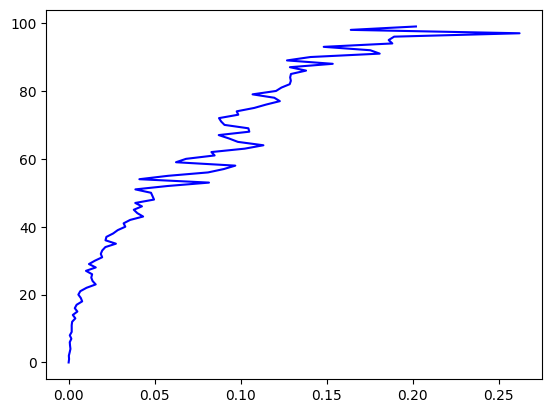

In [119]:
time = np.zeros(100)
timeMATRIX_polar_tree_results_cosne = np.zeros(100)
time[0] = 0
timeMATRIX_polar_tree_results_cosne[0] = 0
for i in range(1, 100):
    time[i] = i
    timeMATRIX_polar_tree_results_cosne[i] = time_polar_tree_results_cosne(i)

plt.plot(timeMATRIX_polar_tree_results_cosne, time, 'blue')
plt.show()

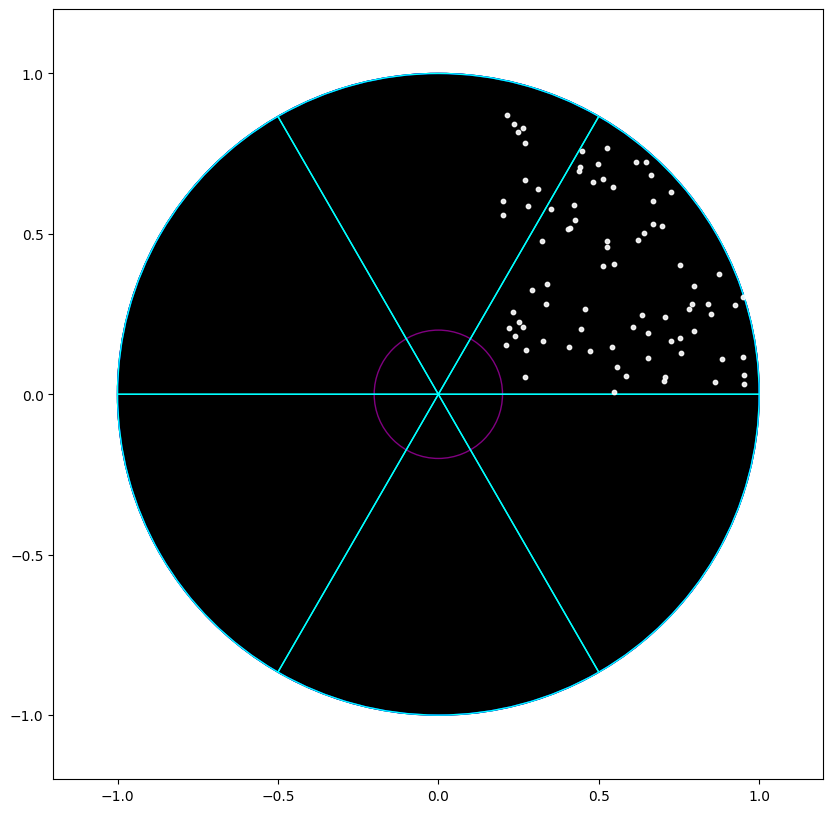

In [66]:
# Display (and save on disk) plots for timing and error (difference exact - tree)
# to compare exact solution against tree-using-equal-area and tree-using-equal-length.

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

# Draw Poincaré disk
poincare_boundary = plt.Circle((0, 0), 1.0, color='black')
inner_circle = plt.Circle((0, 0), 0.2, color='purple', fill=False)
outer_circle = plt.Circle((0, 0), 1.0, color='blue', fill=False)

ax.add_patch(poincare_boundary)
ax.add_patch(inner_circle)
ax.add_patch(outer_circle)

# Define angles for splitting into 6 sections
angles = [0, 60, 120, 180, 240, 300, 360]  # 6 sections

for i in range(len(angles) - 1):
    theta1 = angles[i]
    theta2 = angles[i + 1]
    wedge = patches.Wedge((0, 0), r=1.0, theta1=theta1, theta2=theta2, color='cyan', fill=False)
    ax.add_patch(wedge)

# Example polar points data
num_points = 100
polar_points = np.random.rand(num_points, 2)
polar_points[:, 0] = 0.2 + 0.8 * polar_points[:, 0]  # Adjust radii

ax.scatter(
    x=polar_points[:, 0],
    y=polar_points[:, 1],
    marker='o', alpha=0.9, color='white', s=10.0)

ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-1.2, 1.2)
ax.set_aspect('equal', adjustable='box')
plt.show()